## H2O-3 Regression Tutorial

[**1B. Introduction to Machine Learning with H2O-3 - Regression**](https://training.h2o.ai/products/1b-introduction-to-machine-learning-with-h2o-3-regression)に沿ったチュートリアル

[**H2O 3 - ドキュメント**](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/index.html)  
[**Python - APIドキュメント**](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/index.html)

Linux上で実施（
注意：[XGBoost(H2OXGBoostEstimator)はWindows上で動作しない](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/xgboost.html#limitations)）

#### 目次
- [Initial Setup](#InitialSetup)
    - パッケージのインポート
    - H2Oクラスターの開始
    - データのロード
- [Start Experiment](#StartExperiment)
    - データの確認
    - 学習(train)/検証(valid)/テスト(test)データセットへの分割
    - 利用変数の定義
- [Build an XGBoost Model](#BuildXGBoostModel)
    - XXX
- [Tune the XGBoost Model with H2O GridSearch](#TuneXGBoostModelGridSearch)
    - XXX
- [Test Set Performance](#TestSetPerformance)
    - XXX
    - H2Oクラスターの停止
- [H2O-3の特徴](#H2O-3の特徴)

***

<a id='InitialSetup'></a>
### Initial Setup

In [4]:
#Import H2O and other libraries that will be used in this tutorial 
import h2o
import matplotlib as plt
%matplotlib inline

#Import the Estimators
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators import H2OXGBoostEstimator

#Import h2o grid search 
import h2o.grid 
from h2o.grid.grid_search import H2OGridSearch

In [5]:
#> h2oパッケージのバージョン確認
print(h2o.__version__)

3.30.1.2


In [6]:
#> H2Oクラスターの開始
h2o.init(url='http://localhost:54321')

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,2 mins 02 secs
H2O_cluster_timezone:,Asia/Tokyo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.2
H2O_cluster_version_age:,9 days
H2O_cluster_name:,H2O_from_python_ec2_user_0dcz7d
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.668 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [7]:
#> データのロード
loan_level = h2o.import_file("https://s3.amazonaws.com/data.h2o.ai/DAI-Tutorials/loan_level_500k.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%


連邦住宅金融抵当公庫(Freddie Mac)が提供する約20年間(1999/1-2018/12)の住宅ローン(Fixed-Rate Mortgages)の履歴データ。金利をターゲット変数として回帰の説明に使用する。  
  
[Data Reference](http://www.freddiemac.com/research/datasets/sf_loanlevel_dataset.page)  
[変数等データ詳細に関して](http://www.freddiemac.com/fmac-resources/research/pdf/user_guide.pdf)  
  
行数:500,137、列数:27（約80MB）

***

<a id='StartExperiment'></a>
### Start Experiment

In [8]:
loan_level.head()

CREDIT_SCORE,FIRST_PAYMENT_DATE,FIRST_TIME_HOMEBUYER_FLAG,MATURITY_DATE,METROPOLITAN_STATISTICAL_AREA,MORTGAGE_INSURANCE_PERCENTAGE,NUMBER_OF_UNITS,OCCUPANCY_STATUS,ORIGINAL_COMBINED_LOAN_TO_VALUE,ORIGINAL_DEBT_TO_INCOME_RATIO,ORIGINAL_UPB,ORIGINAL_LOAN_TO_VALUE,ORIGINAL_INTEREST_RATE,CHANNEL,PREPAYMENT_PENALTY_MORTGAGE_FLAG,PRODUCT_TYPE,PROPERTY_STATE,PROPERTY_TYPE,POSTAL_CODE,LOAN_SEQUENCE_NUMBER,LOAN_PURPOSE,ORIGINAL_LOAN_TERM,NUMBER_OF_BORROWERS,SELLER_NAME,SERVICER_NAME,PREPAID,DELINQUENT
669,200206,N,202901,nan,0,1,O,80,33,162000,80,7.12,R,N,FRM,WV,SF,26100,F199Q1000004,P,320,2,Other sellers,Other servicers,TRUE,FALSE
732,199904,N,202903,17140,0,1,O,25,10,53000,25,6.5,R,N,FRM,OH,SF,45200,F199Q1000005,N,360,1,Other sellers,Other servicers,TRUE,FALSE
679,200208,N,202902,15940,30,1,O,91,48,133000,91,6.75,R,N,FRM,OH,SF,44700,F199Q1000007,P,319,1,Other sellers,Other servicers,TRUE,FALSE
721,200209,N,202902,38060,0,1,O,39,13,174000,39,6.625,T,N,FRM,AZ,SF,85200,F199Q1000013,N,318,2,Other sellers,Other servicers,TRUE,FALSE
618,200210,N,202902,10420,25,1,O,85,24,122000,85,6.375,R,N,FRM,OH,SF,44200,F199Q1000015,N,317,2,Other sellers,Other servicers,TRUE,FALSE
738,200211,N,202903,10420,0,1,O,73,44,218000,73,6,R,N,FRM,OH,SF,44300,F199Q1000016,P,317,2,Other sellers,Other servicers,TRUE,FALSE
761,200211,N,202904,nan,0,1,O,73,31,138000,73,6.375,R,N,FRM,SC,PU,29500,F199Q1000017,P,318,2,Other sellers,Other servicers,TRUE,FALSE
707,200211,N,202903,33340,0,1,O,60,57,136000,60,6.25,R,N,FRM,WI,SF,53000,F199Q1000018,C,317,2,Other sellers,Other servicers,TRUE,FALSE
760,200211,N,202903,33340,0,1,O,63,30,79000,63,6.125,R,N,FRM,WI,SF,53000,F199Q1000019,N,317,2,Other sellers,Other servicers,TRUE,FALSE
691,200302,N,202901,15940,0,1,O,65,25,130000,65,5.875,R,N,FRM,OH,SF,44700,F199Q1000023,P,312,2,Other sellers,Other servicers,TRUE,FALSE


金利(ORIGINAL_INTEREST_RATE)の分布の確認

In [9]:
loan_level["ORIGINAL_INTEREST_RATE"].describe()

Rows:500137
Cols:1




,ORIGINAL_INTEREST_RATE
type,real
mins,4.625
mean,7.182686863799322
maxs,11.5
sigma,0.5799408623980744
zeros,0
missing,0
0,7.12
1,6.5
2,6.75


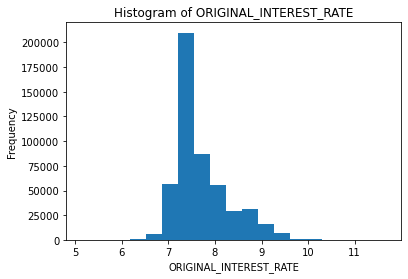

In [10]:
#> ヒストグラムによる分布の確認
loan_level["ORIGINAL_INTEREST_RATE"].hist()

In [11]:
#> 学習/検証/テストデータセットへの分割（学習 : 検証 : テスト = 70% : 15% : 15%）
train, valid, test = loan_level.split_frame([0.7, 0.15], seed=42)
print("＜train/valid/testのデータ数＞")
print( "train:%d valid:%d test:%d" % (train.nrows, valid.nrows, test.nrows ))

＜train/valid/testのデータ数＞
train:350268 valid:74971 test:74898


In [12]:
#> ターゲット変数、特徴量の定義
y = "ORIGINAL_INTEREST_RATE"

ignore = ["ORIGINAL_INTEREST_RATE", 
          "FIRST_PAYMENT_DATE", 
          "MATURITY_DATE", 
          "MORTGAGE_INSURANCE_PERCENTAGE", 
          "PREPAYMENT_PENALTY_MORTGAGE_FLAG", 
          "LOAN_SEQUENCE_NUMBER", 
          "PREPAID", 
          "DELINQUENT", 
          "PRODUCT_TYPE"] 

x = list(set(train.names) - set(ignore))
print(x)

['LOAN_PURPOSE', 'NUMBER_OF_BORROWERS', 'METROPOLITAN_STATISTICAL_AREA', 'OCCUPANCY_STATUS', 'CHANNEL', 'ORIGINAL_LOAN_TO_VALUE', 'PROPERTY_STATE', 'SELLER_NAME', 'FIRST_TIME_HOMEBUYER_FLAG', 'ORIGINAL_UPB', 'PROPERTY_TYPE', 'CREDIT_SCORE', 'NUMBER_OF_UNITS', 'ORIGINAL_DEBT_TO_INCOME_RATIO', 'SERVICER_NAME', 'ORIGINAL_COMBINED_LOAN_TO_VALUE', 'POSTAL_CODE', 'ORIGINAL_LOAN_TERM']


In [13]:
loan_level[x].describe()

Rows:500137
Cols:18




,LOAN_PURPOSE,NUMBER_OF_BORROWERS,METROPOLITAN_STATISTICAL_AREA,OCCUPANCY_STATUS,CHANNEL,ORIGINAL_LOAN_TO_VALUE,PROPERTY_STATE,SELLER_NAME,FIRST_TIME_HOMEBUYER_FLAG,ORIGINAL_UPB,PROPERTY_TYPE,CREDIT_SCORE,NUMBER_OF_UNITS,ORIGINAL_DEBT_TO_INCOME_RATIO,SERVICER_NAME,ORIGINAL_COMBINED_LOAN_TO_VALUE,POSTAL_CODE,ORIGINAL_LOAN_TERM
type,enum,int,int,enum,enum,int,enum,enum,enum,int,enum,int,int,int,enum,int,int,int
mins,,1.0,10180.0,,,6.0,,,,8000.0,,300.0,1.0,1.0,,6.0,600.0,301.0
mean,,1.6302946648262713,30777.82473929504,,,75.71071405720141,,,,136493.48478516805,,712.5362124215468,1.0288902574110184,32.91754051870545,,76.0535707144633,55490.8571382869,359.8554696013299
maxs,,2.0,49740.0,,,100.0,,,,578000.0,,839.0,4.0,65.0,,180.0,99900.0,362.0
sigma,,0.48272535304031594,11333.401144164478,,,14.937717088968643,,,,60968.74306564561,,54.79126197408813,0.21839057355939082,11.111799994455248,,15.139986048512673,29505.38225880303,1.9082507104186504
zeros,,0,0,,,0,,,,0,,0,0,0,,0,0,0
missing,0,247,70149,0,0,9,0,0,0,0,0,2711,3,14929,0,13,31,0
0,P,2.0,nan,O,R,80.0,WV,Other sellers,N,162000.0,SF,669.0,1.0,33.0,Other servicers,80.0,26100.0,320.0
1,N,1.0,17140.0,O,R,25.0,OH,Other sellers,N,53000.0,SF,732.0,1.0,10.0,Other servicers,25.0,45200.0,360.0
2,P,1.0,15940.0,O,R,91.0,OH,Other sellers,N,133000.0,SF,679.0,1.0,48.0,Other servicers,91.0,44700.0,319.0


<a id='BuildXGBoostModel'></a>
### Build an XGBoost Model

[**XGBoost - ドキュメント**](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/xgboost.html#xgboost)  
[**H2OXGBoostEstimator - APIドキュメント**](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2oxgboostestimator)
  
H2O XGBoostはH2Oクラスター上でオリジナルのXGBoost動作させるようビルドされたもの。カテゴリ変数の自動Encodingといった処理も含まれている。

オリジナルのXGBoostの[ドキュメンテーション](https://xgboost.readthedocs.io/en/latest/#)

In [14]:
xgb = H2OXGBoostEstimator(seed=42, 
                          model_id='XGBoost', 
                          nfolds=0, 
                          keep_cross_validation_predictions=False)

%time xgb.train(x=x, y=y, training_frame=train, validation_frame=valid)    # 注：Windowsではサポートされていない

xgboost Model Build progress: |███████████████████████████████████████████| 100%
CPU times: user 354 ms, sys: 19.2 ms, total: 373 ms
Wall time: 26.1 s


- train時にvalidation_frameを指定してホールドアウト法になるので、nfolds=0、keep_cross_validation_predictions=False(それぞれデフォルト)としている

In [15]:
xgb

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost


Model Summary: 


,number_of_trees
,50.0




ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 0.17744636323081306
RMSE: 0.4212438287154045
MAE: 0.30712844420662655
RMSLE: 0.04987056256391179
Mean Residual Deviance: 0.17744636323081306

ModelMetricsRegression: xgboost
** Reported on validation data. **

MSE: 0.18013989282125126
RMSE: 0.4244289019626859
MAE: 0.3108204587914598
RMSLE: 0.0503052982338251
Mean Residual Deviance: 0.18013989282125126

Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2020-09-13 15:37:15,0.086 sec,0.0,6.7088631,6.6836794,45.0088439,6.7047501,6.6798046,44.9536733
,2020-09-13 15:37:18,2.685 sec,1.0,4.7104733,4.6786978,22.1885588,4.7073544,4.6757908,22.1591850
,2020-09-13 15:37:19,3.388 sec,2.0,3.3168272,3.2752196,11.0013425,3.3139314,3.2725993,10.9821415
,2020-09-13 15:37:19,4.025 sec,3.0,2.3488131,2.2927392,5.5169229,2.3462673,2.2904798,5.5049702
,2020-09-13 15:37:20,4.615 sec,4.0,1.6810353,1.6051706,2.8258796,1.6786024,1.6031085,2.8177062
,2020-09-13 15:37:20,5.226 sec,5.0,1.2265317,1.1245445,1.5043799,1.2244424,1.1227758,1.4992593
,2020-09-13 15:37:25,9.387 sec,15.0,0.4526525,0.3278245,0.2048943,0.4522328,0.3289853,0.2045145
,2020-09-13 15:37:29,13.679 sec,25.0,0.4372602,0.3203063,0.1911965,0.4379310,0.3223212,0.1917835
,2020-09-13 15:37:34,18.541 sec,36.0,0.4288518,0.3131603,0.1839138,0.4302024,0.3157913,0.1850741
,2020-09-13 15:37:40,24.753 sec,50.0,0.4212438,0.3071284,0.1774464,0.4244289,0.3108205,0.1801399



Variable Importances: 


variable,relative_importance,scaled_importance,percentage
"SELLER_NAME.NORWESTMORTGAGE,INC",25657.9960938,1.0,0.2391252
OCCUPANCY_STATUS.I,7086.1391602,0.2761766,0.0660408
ORIGINAL_UPB,6440.5112305,0.2510138,0.0600237
ORIGINAL_LOAN_TO_VALUE,5813.7905273,0.2265879,0.0541829
LOAN_PURPOSE.P,4025.8632812,0.1569048,0.0375199
---,---,---,---
PROPERTY_STATE.OK,0.8522186,0.0000332,0.0000079
PROPERTY_STATE.ME,0.5269806,0.0000205,0.0000049
PROPERTY_STATE.MT,0.5000267,0.0000195,0.0000047
PROPERTY_STATE.KS,0.0765716,0.0000030,0.0000007


In [17]:
#> 推定したモデルの設定やハイパーパラメータの確認
xgb.actual_params

{'model_id': 'XGBoost',
 'training_frame': 'py_10_sid_beab',
 'validation_frame': 'py_11_sid_beab',
 'nfolds': 0,
 'keep_cross_validation_models': True,
 'keep_cross_validation_predictions': False,
 'keep_cross_validation_fold_assignment': False,
 'score_each_iteration': False,
 'fold_assignment': None,
 'fold_column': None,
 'response_column': 'ORIGINAL_INTEREST_RATE',
 'ignored_columns': ['PREPAYMENT_PENALTY_MORTGAGE_FLAG',
  'MATURITY_DATE',
  'MORTGAGE_INSURANCE_PERCENTAGE',
  'FIRST_PAYMENT_DATE',
  'DELINQUENT',
  'PREPAID',
  'PRODUCT_TYPE',
  'LOAN_SEQUENCE_NUMBER'],
 'ignore_const_cols': True,
 'offset_column': None,
 'weights_column': None,
 'stopping_rounds': 0,
 'stopping_metric': None,
 'stopping_tolerance': 0.001,
 'max_runtime_secs': 0.0,
 'seed': 42,
 'distribution': 'gaussian',
 'tweedie_power': 1.5,
 'categorical_encoding': 'OneHotInternal',
 'quiet_mode': True,
 'checkpoint': None,
 'export_checkpoints_dir': None,
 'ntrees': 50,
 'max_depth': 6,
 'min_rows': 1.0,
 'm

- 各内容に関しての[ドキュメント](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/xgboost.html#defining-an-xgboost-model)、[APIドキュメント](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2oxgboostestimator)

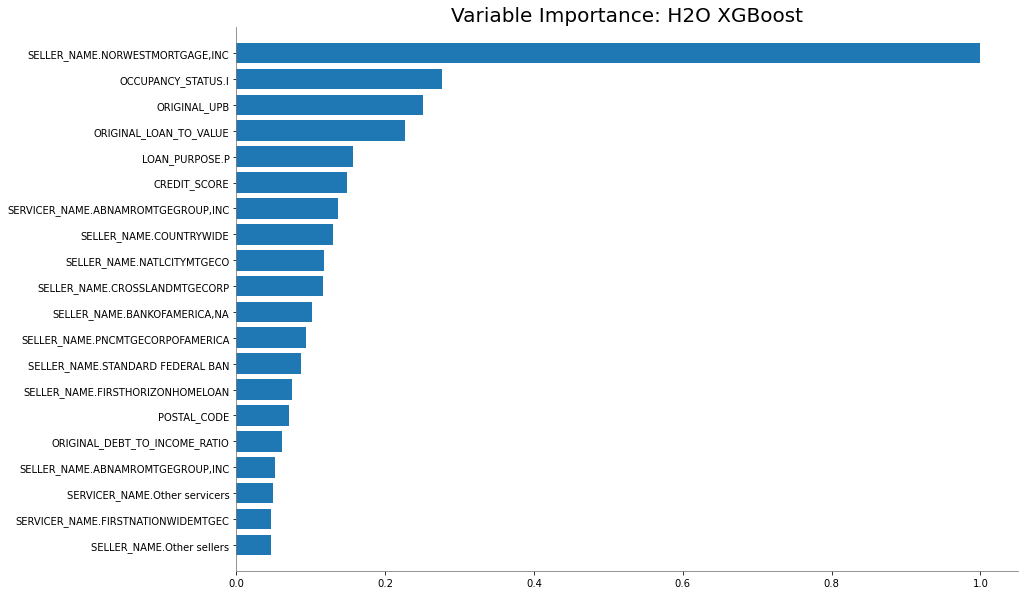

In [19]:
#> 変数重要度の表示
xgb.varimp_plot(20)

- 値自体を取得する場合 `xgb.varimp()`
- H2ORandomForestEstimator,H2OGradientBoostingEstimatorと異なり、カテゴリ変数はone-hot encodingされた形式で表示

In [26]:
#> validデータに対する予測を実施
xgb_def_pred = xgb.predict(valid)
xgb_def_pred.head(5)

xgboost prediction progress: |████████████████████████████████████████████| 100%


predict
7.20097
6.87724
7.0235
7.25526
7.02648


In [27]:
#> 実測値との比較
xgb_def_pred.cbind(valid['ORIGINAL_INTEREST_RATE'])

predict,ORIGINAL_INTEREST_RATE
7.20097,5.875
6.87724,6.75
7.0235,7.75
7.25526,6.625
7.02648,6.75
7.38137,7
6.8168,7
7.40214,7
7.06643,7.25
7.00728,7


In [28]:
#> validデータでの結果の取得
default_xgb_per = xgb.model_performance(valid)

In [29]:
print('AUC on train data: ', xgb.rmse())
print('AUC on valid data: ', default_xgb_per.rmse())

AUC on train data:  0.4212438287154045
AUC on valid data:  0.4244289019626859


***

<a id='BuildDeepLearningModel'></a>
### Build a Deep Learning Model

[**Deep Learning (Neural Networks) - ドキュメント**](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/deep-learning.html)  
[**H2ODeepLearningEstimator - APIドキュメント**](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2odeeplearningestimator)

In [31]:
#> H2Oクラスターの終了
h2o.cluster().shutdown()

H2O session _sid_beab closed.
